# Parameters

In [1373]:
NSIDE = 8
NUMPIX = 12 * NSIDE ** 2
DEPTH = 4
SHOW_IMAGES = True

RECT = True

# Helper Functions

In [1374]:
from torchvision.utils import save_image
import os
import torch

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device


def make_dir():
    image_dir = 'Saved_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_img(img, name):
    img = img.view(img.size(0), 1, 12 * NSIDE // 8, 64 * NSIDE // 8)
    save_image(img, name)

### Set Device

In [1375]:
device = get_device()
base = torch.float32

#pin to gpu
device

'cpu'

### Set seed.

In [1376]:
from src.utils import set_seed
set_seed(2021)

# 1. Load in Data

In [1377]:
'''
Open the file.
'''

import pickle
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

file_name = f"split_sphere_datasets_NSIDE{NSIDE}.pkl"

f = open(file_name, "rb")
dataset = pickle.load(f)
f.close()

print(np.array(dataset))

[{'data': array([0.63302202, 2.89220065]), 'label': array([4.66805340e-07, 5.33040480e-04, 9.42961191e-05, ...,
        6.66007057e-52, 4.22206507e-54, 2.62681859e-64])}
 {'data': array([2.3509821, 0.8276956]), 'label': array([4.37942708e-098, 8.19076135e-107, 8.26987782e-118, ...,
        2.81413164e+000, 3.92787699e+000, 3.01207782e+000])}
 {'data': array([0.59406139, 3.68911751]), 'label': array([3.79277429e-07, 1.42453033e-04, 4.19383619e-03, ...,
        1.22863528e-58, 7.51727914e-54, 4.48584985e-62])}
 ...
 {'data': array([1.96275226, 3.9636191 ]), 'label': array([7.82215184e-82, 1.37044778e-73, 1.51726569e-65, ...,
        3.29541135e-02, 5.20673990e-01, 4.14026489e-02])}
 {'data': array([2.93389288, 0.19085046]), 'label': array([1.21114363e-160, 8.60478471e-176, 2.30847850e-180, ...,
        7.22061039e-008, 2.31815890e-007, 7.58452651e-011])}
 {'data': array([1.37185698, 5.94539712]), 'label': array([1.39445050e-31, 4.61463637e-39, 2.30458030e-36, ...,
        2.92638261e-21,

# 2. Create Input and Output Arrays

In [1378]:
'''

Create the training and validation datasets. Do any necessary reshaping. 

'''

import numpy as np

x_combined = []
y_combined = []



NUM_CHANNELS = 1

for i in range(len(dataset)):
    x = dataset[i]['data']
    y = dataset[i]['label']

    x_combined.append(x)
    y_combined.append(y)
    
x_combined = np.array(x_combined)
y_combined = np.array(y_combined)

print("x_combined shape: ", x_combined.shape)
print("y_combined shape: ", y_combined.shape)

x_combined shape:  (2048, 2)
y_combined shape:  (2048, 3072)


# 3. Split into Training, Val, and Test. Also Reshape into Rectangle if Specified.

In [1379]:
# train_len = int(0.7 * len(y_combined)) # 70%
# val_len = int(0.15 * len(y_combined)) # 15%
# test_len = len(y_combined) - train_len - val_len # 15%

train_len = 1536
val_len = 256
test_len = 256


x_train = x_combined[:train_len]
x_val = x_combined[train_len : train_len + val_len]
x_test = x_combined[train_len + val_len:]

y_train = y_combined[:train_len]
y_val = y_combined[train_len : train_len + val_len]
y_test = y_combined[train_len + val_len:]

if RECT:
    # NOTE: Can change based on input size of data
    # For now, default to 12, 64 size for NSIDE 8 that is scaled up for larger NSIDEs. 
    length = 32 * NSIDE // 8
    width = 24 * NSIDE // 8

    y_train = y_train.reshape((len(y_train), DEPTH, width, length))
    y_val = y_val.reshape((len(y_val), DEPTH, width, length))
    y_test = y_test.reshape((len(y_test), DEPTH, width, length))


print("x_train shape: ", x_train.shape)
print("x_val shape: ", x_val.shape)
print("x_test shape: ", x_test.shape)
print()

print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (1536, 2)
x_val shape:  (256, 2)
x_test shape:  (256, 2)

y_train shape:  (1536, 4, 12, 64)
y_val shape:  (256, 4, 12, 64)
y_test shape:  (256, 4, 12, 64)


# 4. Create data loaders

In [1380]:
# constants
NUM_EPOCHS = 200
LEARNING_RATE = 0.01
BATCH_SIZE = 64 # previously 1

In [1381]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

train_set = TensorDataset(torch.tensor(x_train).to(dtype=base, device=device), torch.tensor(y_train).to(dtype=base, device=device))
val_set = TensorDataset(torch.tensor(x_val).to(dtype=base, device=device), torch.tensor(y_val).to(dtype=base, device=device))
test_set = TensorDataset(torch.tensor(x_test).to(dtype=base, device=device), torch.tensor(y_test).to(dtype=base, device=device))

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=True)

# 5. Define Model Classes

In [1382]:
from torch.nn import Module, Conv2d, Sequential, ConvTranspose2d, ReLU, MaxPool2d, Linear, Conv3d, Tanh


class ConvExpand(Module): 
    def __init__(self, linear_layers, conv_layers, mid_rect_size, batch_size, num_channels):
        super().__init__()

        # Put encoder layers in Sequential container
        # First increase from 1 --> 64 channels
        # Keep decreasing number of channels
        
        self.linear_layers = linear_layers
        self.conv_layers = conv_layers

        self.mid_rect_size = mid_rect_size
        self.batch_size = batch_size
        self.num_channels = num_channels

    # Run x through each layer
    def forward(self, x):
        for layer in self.linear_layers:
            x = layer(x)
        

        # IMPORTANT: Reshaping output of linear layer into rect form
        # Need to reshape into (BATCH SIZE, NUM_CHANNELS, ... )
        # usually batch size is first parameter, but sometimes if smaller batch then just use whatever x has
        # originally self.batch_size as first param, but now this
        x = x.view(x.size(0), 4, self.mid_rect_size[0], self.mid_rect_size[1])
        
        for layer in self.conv_layers:
            # print(x.shape)
            x = layer(x)
        
        # print(x.detach().numpy().shape)
        # print()
        return x
        

In [1383]:

fcmodel8 = Sequential(
           Linear(2, 12),
           ReLU(),
           Linear(12, 384),
           ReLU(),
           Linear(384, 1536),
           ReLU(),
           Linear(1536, 3072)
   )

In [1384]:
# IMPORTANT: change linear layer output to batch size * 256 so dimensions match? hmm
lin8 = Sequential (
   Linear(2, 12),
   ReLU(),
   Linear(12, 384),
   ReLU(),
   Linear(384, 3072),
)


mid_rect_size = (width, length)


conv8 = Sequential (
   Conv2d(4, 16, kernel_size=3, padding=1),
   ReLU(),
   Conv2d(16, 4, kernel_size=3, padding=1),
)



expand8 = ConvExpand(lin8, conv8, mid_rect_size, BATCH_SIZE, NUM_CHANNELS)

In [1385]:
model = expand8

# 6. Create Trainer

In [1386]:
import torch.optim as optim
from torch.nn import MSELoss

# Use MSE Loss
# need to specify cpu
criterion = MSELoss().to(dtype=base, device=device)

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [1387]:
# Function to evaluate performance of model on some data
def eval_performance(model, data_loader):
    # Set model to evaluation mode to conserve memory 
    model.eval()

    # Don't want to waste memory on gradients
    with torch.no_grad():
        total_loss = 0.0
        for x, y in data_loader:
            pred = model(x)

            total_loss += criterion(pred, y)
            
        
        # Revert back to train mode
        model.train()

        return total_loss / len(data_loader)

In [1388]:


train_loss_hist = []
val_loss_hist = []
epoch = 0

def train(model, train_loader, NUM_EPOCHS):
    global train_loss_hist
    global val_loss_hist
    global epoch

    while epoch < NUM_EPOCHS:
        running_loss = 0.0

        # Go through each batch of the data (can pass in entire batch at once!)
        # batch - number of training examples for one forward/backward pass. So pass in batch data values then update weights. 
        for x_vals, y_vals in train_loader:
            torch.cuda.empty_cache()

            # Remember, it's in batches. 
            
            '''

            Reset gradients to 0 so updating of weights can be done correctly.

            When we do loss.backward(), gradients are calculated. Then, optimizer.step() does gradient descent.
            For the next batch, we don't want these gradients to still be lingering (because a new input will have new gradients).
            Thus, we have to reset the gradients to 0. 

            NOTE: This is not the same as setting the weights to 0! We are just resetting the calculated gradients.
            
            '''
            optimizer.zero_grad()

            # Calculate model outputs
            outputs = model(x_vals)

            # Calculate loss
            loss = criterion(outputs, y_vals)

            # Calculate gradients 
            loss.backward()

            # Do gradient descent to update the weights.
            optimizer.step()

            running_loss += loss.item()


        loss = running_loss / len(train_loader)
        train_loss_hist.append(loss)

        torch.cuda.empty_cache()


        # running_val_loss = 0.0
        # # Calculate val loss
        # for x, y in val_loader:
        #     optimizer.zero_grad()
            
            
        #     # Calculate model outputs
        #     val_outputs = model(x)

        #     loss = criterion(val_outputs, y)
        #     running_val_loss += loss

        val_loss = eval_performance(model, val_loader)
        val_loss_hist.append(val_loss)

        

        print(f'Epoch {epoch + 1} of {NUM_EPOCHS}, Train Loss: {loss}, Val Loss: {val_loss}')
        # print(f'Epoch {epoch + 1} of {NUM_EPOCHS}, Train Loss: {loss}')

        # # Saving a full batch!
        # if epoch % 2 == 0:
        #     save_img(y_vals.cpu().data, name='./Cone_Images/truth_batch_{}.png'.format(epoch))
        #     save_img(outputs.cpu().data, name='./Cone_Images/predicted_batch_{}.png'.format(epoch))
        
        epoch += 1

# Train Model

In [1389]:
train(model, train_loader, NUM_EPOCHS)

Epoch 1 of 200, Train Loss: 0.5268142893910408, Val Loss: 0.4369874596595764
Epoch 2 of 200, Train Loss: 0.3915676176548004, Val Loss: 0.3491758406162262
Epoch 3 of 200, Train Loss: 0.3169143895308177, Val Loss: 0.2901599407196045
Epoch 4 of 200, Train Loss: 0.25294065847992897, Val Loss: 0.22461813688278198
Epoch 5 of 200, Train Loss: 0.201821801563104, Val Loss: 0.1986921727657318
Epoch 6 of 200, Train Loss: 0.1777092143893242, Val Loss: 0.15452343225479126
Epoch 7 of 200, Train Loss: 0.15091213708122572, Val Loss: 0.14056137204170227
Epoch 8 of 200, Train Loss: 0.14243616225818792, Val Loss: 0.12705165147781372
Epoch 9 of 200, Train Loss: 0.11908489683022101, Val Loss: 0.11586926877498627
Epoch 10 of 200, Train Loss: 0.10620038397610188, Val Loss: 0.10353833436965942
Epoch 11 of 200, Train Loss: 0.11140918172895908, Val Loss: 0.10693886131048203
Epoch 12 of 200, Train Loss: 0.09828861026714246, Val Loss: 0.08731596916913986
Epoch 13 of 200, Train Loss: 0.08478088366488616, Val Loss:

KeyboardInterrupt: 

0.00019774794


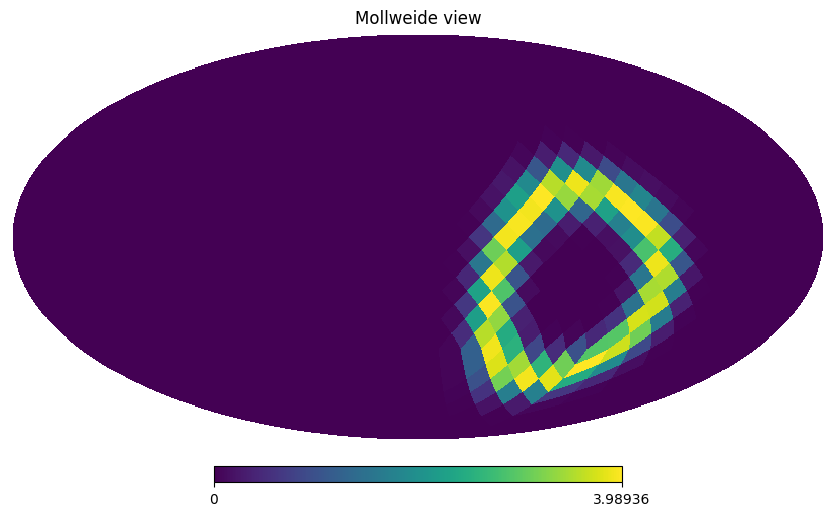

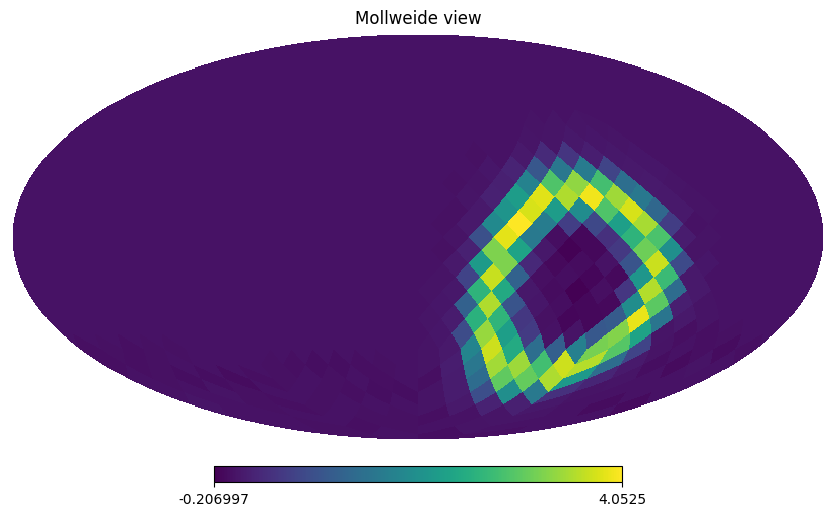

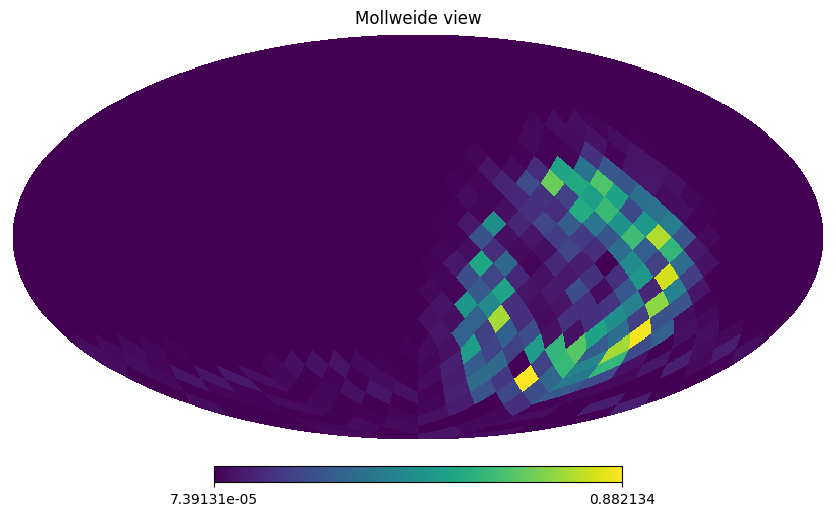

In [ ]:


def display_sample(model, data_loader):
    for x, y in data_loader:
        # Set model to evaluation mode to conserve memory 
        model.eval()

        # Don't want to waste memory on gradients
        with torch.no_grad():

            pred = model(x)

            truth = torch.reshape(y[0], (DEPTH, NUMPIX, ))[2].detach().numpy()
            model_pred = np.reshape(pred[0].detach().numpy(), (DEPTH, NUMPIX, ))[2]

            diff = np.absolute(model_pred - truth)
            
            # [0] because 1 channel so need to go inside
            hp.mollview(truth)
            hp.mollview(model_pred)
            hp.mollview(diff)
            
            print(np.median(diff))

            # set back to train mode
            model.train()
            break
    
if SHOW_IMAGES:
    display_sample(model, val_loader)

## Create Dataloader of Model Outputs 

In [ ]:
def save_model_outputs(model, path):
    preds = []
    truths = []

    for x, y in val_loader:
    # Set model to evaluation mode to conserve memory 
        model.eval()

        # Don't want to waste memory on gradients
        with torch.no_grad():

            pred = model(x)

            pred_np = pred.detach().numpy()
            truth_np = y.detach().numpy()

            new_shape = (4, 12, 64)

            # batched right now, so need to unbatch 
            for i in range(len(pred_np)):

                # need to also reshape each element
                pred_reshape = np.reshape(pred_np[i], new_shape)
                truth_reshape = np.reshape(truth_np[i], new_shape)

                print(pred_reshape.shape)

                # need to add each depth individually
                for depth in range(4):
                    # [0] since first 1 dimension
                    preds.append(pred_reshape[depth])
                    truths.append(truth_reshape[depth])
    
    preds = np.array(preds)
    truths = np.array(truths)

    print(preds.shape)
            
    combined_set = TensorDataset(torch.tensor(preds).to(dtype=base, device=device), torch.tensor(truths).to(dtype=base, device=device))
    loader = DataLoader(combined_set, 1, shuffle=True)
    
    torch.save(loader, path)

    # set back to train mode
    model.train()

name = f"saved-pred-outputs/output-loader-model_NSIDE{NSIDE}_trainloss{final_train_loss}_valloss{final_val_loss}_epochs{epoch}.pth"
save_model_outputs(model, name)

(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 12, 64)
(4, 